In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import ks_2samp

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


### Loading Starting Moneyline Data

In [3]:
df = pd.read_parquet('s3://moneygans-data/basketball_nba/starting_money/starting_money_agg/starting_money_all.parquet', engine='pyarrow')[['pos_money','neg_money']]
real_df = df

#### Empirical Starting Moneyline Distribution

/Users/jake/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/jake/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


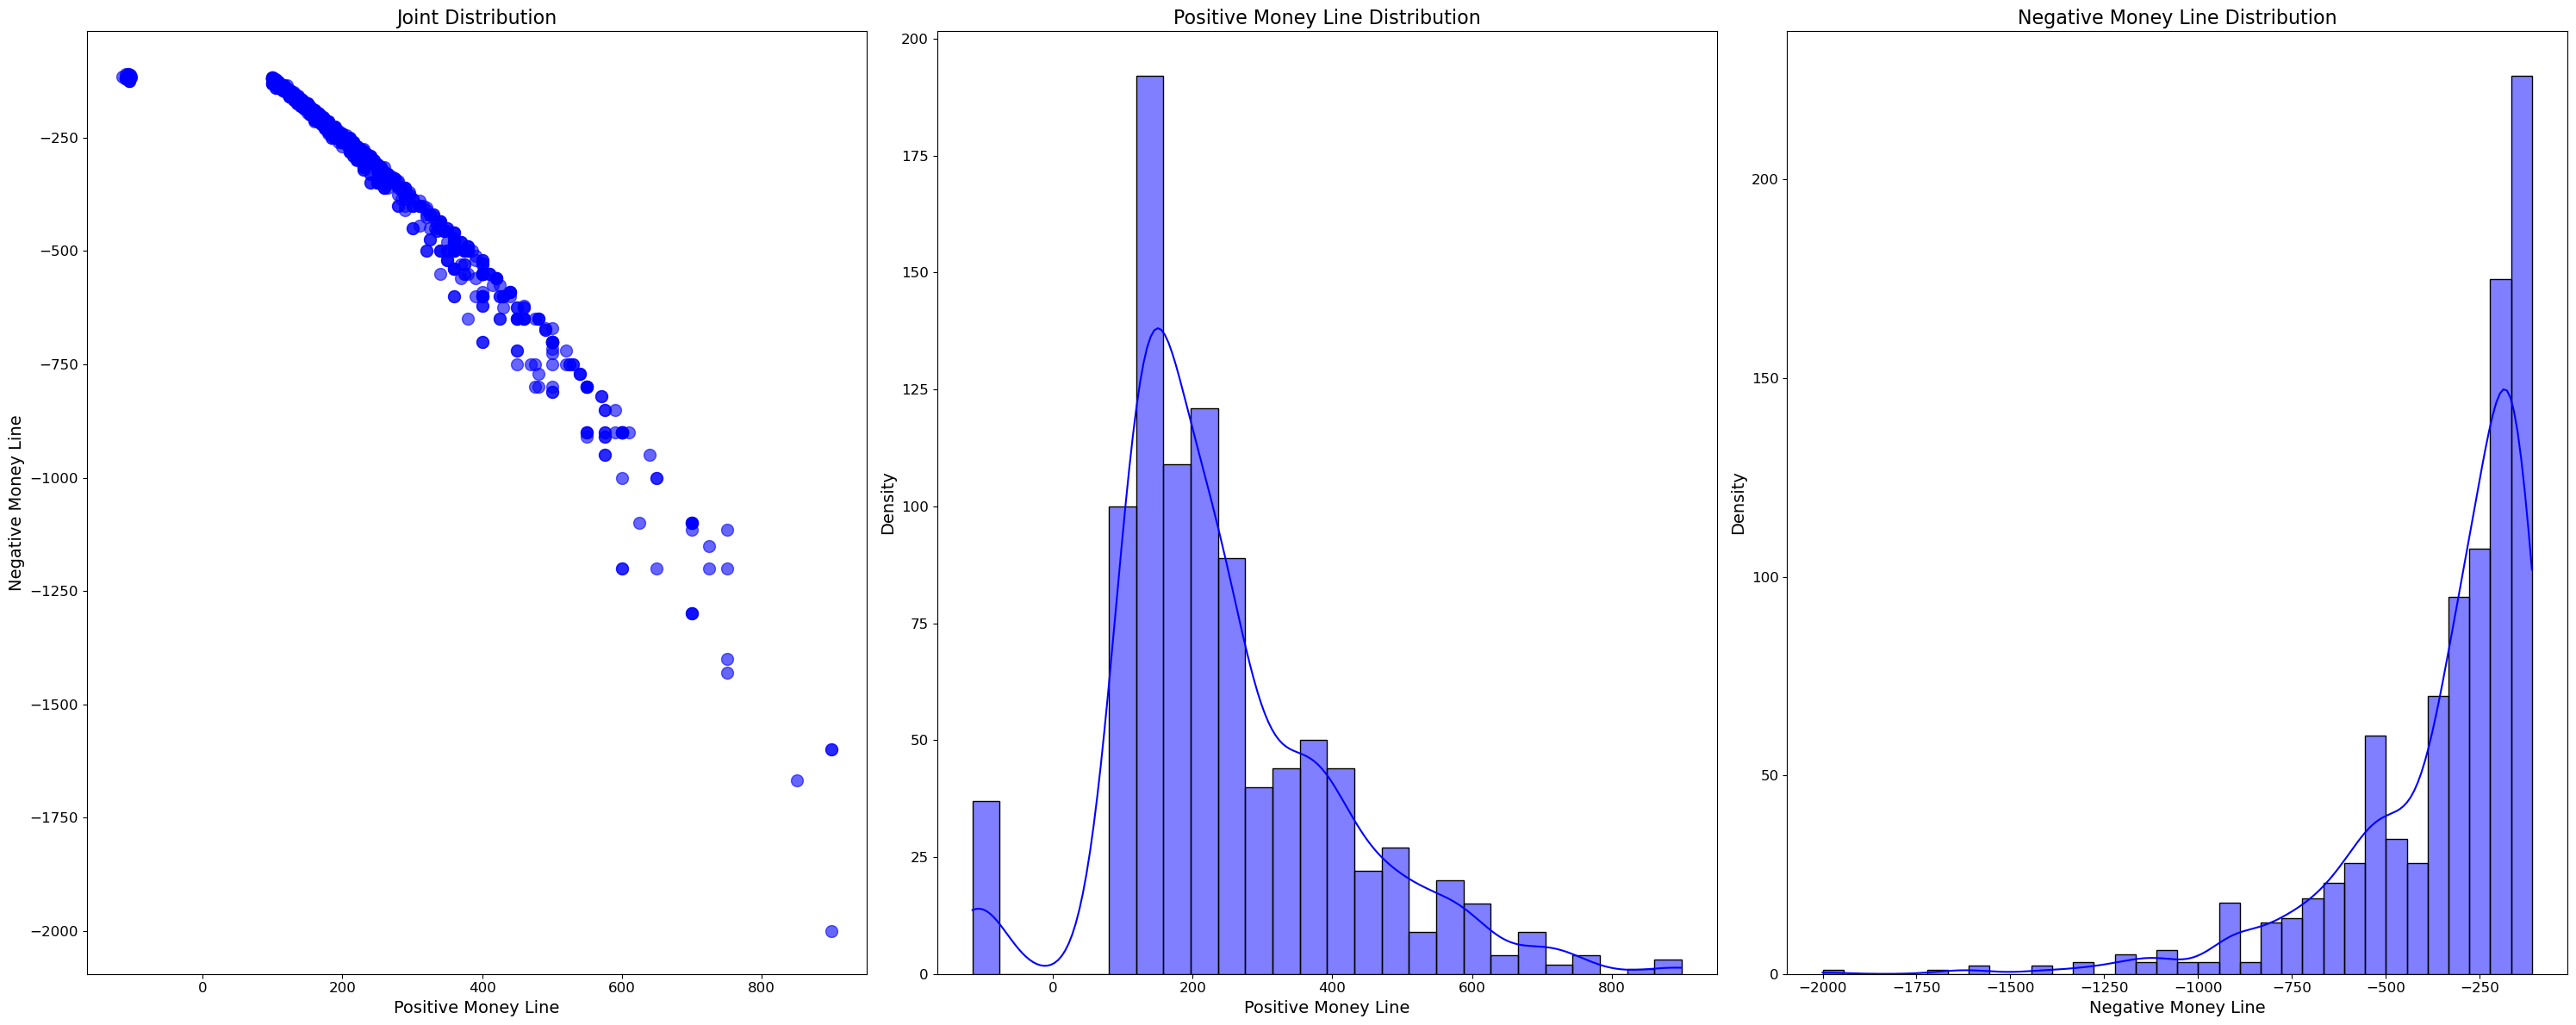

In [4]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 12))

# Joint distribution
ax1.scatter(df['pos_money'], df['neg_money'], color='blue', alpha=0.6, s=100)
ax1.set_title('Joint Distribution', fontsize=16)
ax1.set_xlabel('Positive Money Line', fontsize=14)
ax1.set_ylabel('Negative Money Line', fontsize=14)
ax1.tick_params(axis='both', which='major', labelsize=12)

# Positive moneyline distribution
sns.histplot(df['pos_money'], kde=True, color='blue', ax=ax2)
ax2.set_title('Positive Money Line Distribution', fontsize=16)
ax2.set_xlabel('Positive Money Line', fontsize=14)
ax2.set_ylabel('Density', fontsize=14)
ax2.tick_params(axis='both', which='major', labelsize=12)

# Negative moneyline distribution  
sns.histplot(df['neg_money'], kde=True, color='blue', ax=ax3)
ax3.set_title('Negative Money Line Distribution', fontsize=16)
ax3.set_xlabel('Negative Money Line', fontsize=14)
ax3.set_ylabel('Density', fontsize=14)
ax3.tick_params(axis='both', which='major', labelsize=12)

plt.tight_layout()
plt.show()

##### Converting df to array

In [5]:
data = df.values.astype(np.float32)
data.shape

(942, 2)

## Spectral Normalization, Larger Network with Dropout

In [6]:
# Create a PyTorch dataset and dataloader
# Convert data to PyTorch tensor
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)  # Fit and transform the data first
real_data = torch.tensor(scaled_data)
batch_size = 64  # Adjust batch size as needed
dataset = TensorDataset(real_data)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Define the Generator network with Batch Normalization, Dropout, and more layers
class Generator(nn.Module):
    def __init__(self, noise_dim=10, output_dim=2):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(noise_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, output_dim),
        )

    def forward(self, z):
        return self.model(z)

# Define the Critic network with Spectral Normalization, Dropout, and more layers
class Critic(nn.Module):
    def __init__(self, input_dim=2):
        super(Critic, self).__init__()
        self.model = nn.Sequential(
            nn.utils.spectral_norm(nn.Linear(input_dim, 256)),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.utils.spectral_norm(nn.Linear(256, 512)),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.utils.spectral_norm(nn.Linear(512, 256)),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.utils.spectral_norm(nn.Linear(256, 1)),
        )

    def forward(self, x):
        return self.model(x)

# Hyperparameters
noise_dim = 10
n_epochs = 5000  # Increase epochs for better results
lr = 1e-4
n_critic = 5  # Number of critic iterations per generator iteration

# Initialize models and optimizers
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
if device.type == 'cuda':
    print("GPU:", torch.cuda.get_device_name(0))
G = Generator(noise_dim=noise_dim, output_dim=2).to(device)
C = Critic(input_dim=2).to(device)

optimizer_G = optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.9))
optimizer_C = optim.Adam(C.parameters(), lr=lr, betas=(0.5, 0.9))

# Lists to store loss values for visualization
losses_G = []
losses_C = []

# Training loop
for epoch in range(1, n_epochs + 1):
    for i, data_batch in enumerate(dataloader):
        real_samples = data_batch[0].to(device)
        batch_size = real_samples.size(0)

        # Train Critic
        for _ in range(n_critic):
            z = torch.randn(batch_size, noise_dim).to(device)
            fake_samples = G(z).detach()

            critic_real = C(real_samples)
            critic_fake = C(fake_samples)

            loss_C = -(torch.mean(critic_real) - torch.mean(critic_fake))

            optimizer_C.zero_grad()
            loss_C.backward()
            optimizer_C.step()

        # Train Generator
        z = torch.randn(batch_size, noise_dim).to(device)
        fake_samples = G(z)
        critic_fake = C(fake_samples)
        loss_G = -torch.mean(critic_fake)

        optimizer_G.zero_grad()
        loss_G.backward()
        optimizer_G.step()

    # Store losses for plotting
    losses_G.append(loss_G.item())
    losses_C.append(loss_C.item())

    if epoch % 100 == 0 or epoch == 1:
        print(f"Epoch {epoch}, Loss C: {loss_C.item():.4f}, Loss G: {loss_G.item():.4f}")

# Generate synthetic data
with torch.no_grad():
    z = torch.randn(len(real_data), noise_dim).to(device)
    generated_samples = G(z).cpu().numpy()

# Inverse transform the data if normalized
generated_samples = scaler.inverse_transform(generated_samples)
real_data_np = scaler.inverse_transform(real_data.numpy())

# Convert to DataFrames for easier plotting
real_df = pd.DataFrame(real_data_np, columns=['pos_money', 'neg_money'])
gen_df = pd.DataFrame(generated_samples, columns=['pos_money', 'neg_money'])




Using device: cpu
Epoch 1, Loss C: -0.3840, Loss G: -0.0683
Epoch 100, Loss C: -0.0398, Loss G: -0.4254
Epoch 200, Loss C: 0.0070, Loss G: -0.2627
Epoch 300, Loss C: -0.0403, Loss G: -0.1321
Epoch 400, Loss C: -0.0329, Loss G: -0.3717
Epoch 500, Loss C: -0.0047, Loss G: -0.3367
Epoch 600, Loss C: 0.0112, Loss G: -0.3565
Epoch 700, Loss C: -0.0105, Loss G: -0.3894
Epoch 800, Loss C: 0.0020, Loss G: -0.2990
Epoch 900, Loss C: -0.0095, Loss G: -0.2300
Epoch 1000, Loss C: -0.0083, Loss G: -0.1878
Epoch 1100, Loss C: 0.0040, Loss G: -0.1690
Epoch 1200, Loss C: -0.0023, Loss G: -0.1090
Epoch 1300, Loss C: 0.0048, Loss G: -0.0274
Epoch 1400, Loss C: -0.0047, Loss G: -0.1119
Epoch 1500, Loss C: -0.0241, Loss G: -0.1511
Epoch 1600, Loss C: 0.0004, Loss G: -0.1414
Epoch 1700, Loss C: 0.0057, Loss G: -0.1763
Epoch 1800, Loss C: 0.0016, Loss G: -0.1893
Epoch 1900, Loss C: 0.0047, Loss G: -0.1717
Epoch 2000, Loss C: 0.0100, Loss G: -0.0990
Epoch 2100, Loss C: 0.0031, Loss G: -0.0965
Epoch 2200, Los

In [7]:
gen_df.to_csv("../experiments/WGAN_Final_Gen_Data.csv", index=False)
# Save the losses to a CSV file
losses_df = pd.DataFrame({
    'Generator_Loss': losses_G,
    'Critic_Loss': losses_C
})
losses_df.to_csv("../experiments/WGAN_Final_Losses.csv", index=False)


# Save the trained models
torch.save({
    'generator_state_dict': G.state_dict(),
    'critic_state_dict': C.state_dict(),
    'optimizer_G_state_dict': optimizer_G.state_dict(),
    'optimizer_C_state_dict': optimizer_C.state_dict(),
    'epoch': n_epochs,
    'losses_G': losses_G,
    'losses_C': losses_C
}, 'wgan_model.pth')

# Save the scaler for data normalization
import joblib
joblib.dump(scaler, 'wgan_scaler.pkl')

# gen_df = pd.read_csv('../experiments/WGAN_Final_Gen_Data.csv')
# gen_df

['wgan_scaler.pkl']

In [8]:
# # Load the saved model
# checkpoint = torch.load('wgan_model.pth')
# G.load_state_dict(checkpoint['generator_state_dict'])
# C.load_state_dict(checkpoint['critic_state_dict'])
# optimizer_G.load_state_dict(checkpoint['optimizer_G_state_dict'])
# optimizer_C.load_state_dict(checkpoint['optimizer_C_state_dict'])

# # Load the scaler
# scaler = joblib.load('wgan_scaler.pkl')

In [9]:
def plot_real_vs_generated(real_df, gen_df):
    """
    Creates a scatter plot comparing real and generated data points.
    
    Args:
        real_df (DataFrame): DataFrame containing real data
        gen_df (DataFrame): DataFrame containing generated data
    """
    plt.figure(figsize=(10, 7))
    plt.scatter(real_df['pos_money'], real_df['neg_money'], label='Real Data', color='blue', alpha=0.6)
    plt.scatter(gen_df['pos_money'], gen_df['neg_money'], label='Generated Data', color='orange', alpha=0.6)
    plt.title('Real Data vs. Generated Data')
    plt.xlabel('Positive Money Line')
    plt.ylabel('Negative Money Line')
    plt.legend()
    plt.show()

def plot_training_losses(losses_G, losses_C):
    """
    Plots the training losses for both Generator and Critic over epochs.
    
    Args:
        losses_G (list): List of Generator losses
        losses_C (list): List of Critic losses
    """
    plt.figure(figsize=(10, 5))
    plt.plot(losses_G, label='Generator Loss')
    plt.plot(losses_C, label='Critic Loss')
    plt.title('Generator and Critic Losses During Training')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def plot_feature_distributions(real_df, gen_df):
    """
    Creates histograms comparing the distribution of features between real and generated data.
    
    Args:
        real_df (DataFrame): DataFrame containing real data
        gen_df (DataFrame): DataFrame containing generated data
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    sns.histplot(real_df['pos_money'], kde=True, color='blue', label='Real', ax=axes[0])
    sns.histplot(gen_df['pos_money'], kde=True, color='orange', label='Generated', ax=axes[0])
    axes[0].set_title('Distribution of Positive Money Line')
    axes[0].legend()

    sns.histplot(real_df['neg_money'], kde=True, color='blue', label='Real', ax=axes[1])
    sns.histplot(gen_df['neg_money'], kde=True, color='orange', label='Generated', ax=axes[1])
    axes[1].set_title('Distribution of Negative Money Line')
    axes[1].legend()
    plt.show()

def plot_joint_kde(real_df, gen_df):
    """
    Creates a kernel density estimation plot for the joint distribution of features.
    
    Args:
        real_df (DataFrame): DataFrame containing real data
        gen_df (DataFrame): DataFrame containing generated data
    """
    plt.figure(figsize=(10, 7))
    sns.kdeplot(data=real_df, x='pos_money', y='neg_money', cmap='Blues', fill=True, thresh=0, levels=10, label='Real Data')
    sns.kdeplot(data=gen_df, x='pos_money', y='neg_money', cmap='Oranges', fill=True, thresh=0, levels=10, label='Generated Data')
    plt.title('KDE of Real vs. Generated Data')
    plt.xlabel('Positive Money Line')
    plt.ylabel('Negative Money Line')
    plt.legend()
    plt.show()

def plot_2d_histogram(real_df, gen_df):
    """
    Creates a 2D histogram (hexbin plot) comparing real and generated data distributions.
    
    Args:
        real_df (DataFrame): DataFrame containing real data
        gen_df (DataFrame): DataFrame containing generated data
    """
    plt.figure(figsize=(10, 7))
    plt.hexbin(real_df['pos_money'], real_df['neg_money'], gridsize=30, cmap='Blues', alpha=0.5)
    plt.hexbin(gen_df['pos_money'], gen_df['neg_money'], gridsize=30, cmap='Oranges', alpha=0.5)
    plt.title('2D Histogram of Real and Generated Data')
    plt.xlabel('Positive Money Line')
    plt.ylabel('Negative Money Line')
    plt.colorbar(label='Counts')
    plt.show()

def perform_ks_test(real_df, gen_df):
    """
    Perform Kolmogorov-Smirnov tests for both marginal distributions and joint distribution.
    Compares real data with generated data.
    
    Args:
        real_df (DataFrame): DataFrame containing real data
        gen_df (DataFrame): DataFrame containing generated data
    """
    from scipy import stats
    
    # Perform KS test for positive moneyline
    ks_stat_pos, p_value_pos = stats.ks_2samp(real_df['pos_money'], gen_df['pos_money'])
    
    # Perform KS test for negative moneyline  
    ks_stat_neg, p_value_neg = stats.ks_2samp(real_df['neg_money'], gen_df['neg_money'])
    
    # Perform 2D KS test for joint distribution
    real_joint = np.column_stack((real_df['pos_money'], real_df['neg_money']))
    gen_joint = np.column_stack((gen_df['pos_money'], gen_df['neg_money']))
    ks_stat_2d, p_value_2d = stats.ks_2samp(real_joint.ravel(), gen_joint.ravel())
    
    # Print results
    print("Kolmogorov-Smirnov Test Results:")
    print("\nPositive Moneyline:")
    print(f"KS statistic: {ks_stat_pos:.4f}")
    print(f"p-value: {p_value_pos:.4f}")
    print(f"Null hypothesis (distributions are the same): {'Not rejected' if p_value_pos > 0.05 else 'Rejected'}")
    
    print("\nNegative Moneyline:")
    print(f"KS statistic: {ks_stat_neg:.4f}") 
    print(f"p-value: {p_value_neg:.4f}")
    print(f"Null hypothesis (distributions are the same): {'Not rejected' if p_value_neg > 0.05 else 'Rejected'}")
    
    print("\nJoint Distribution:")
    print(f"KS statistic: {ks_stat_2d:.4f}")
    print(f"p-value: {p_value_2d:.4f}")
    print(f"Null hypothesis (distributions are the same): {'Not rejected' if p_value_2d > 0.05 else 'Rejected'}")

def calculate_wasserstein_distances(real_df, gen_df):
    """
    Calculate Wasserstein distances between real and generated distributions
    for both positive and negative moneylines.
    
    Args:
        real_df (DataFrame): DataFrame containing real data
        gen_df (DataFrame): DataFrame containing generated data
        
    Returns:
        dict: Dictionary containing Wasserstein distances for both distributions
    """
    from scipy.stats import wasserstein_distance
    
    # Calculate Wasserstein distance for positive moneyline
    wd_pos = wasserstein_distance(real_df['pos_money'], gen_df['pos_money'])
    
    # Calculate Wasserstein distance for negative moneyline
    wd_neg = wasserstein_distance(real_df['neg_money'], gen_df['neg_money'])
    
    # Print results
    print("Wasserstein Distance Results:")
    print(f"\nPositive Moneyline: {wd_pos:.4f}")
    print(f"Negative Moneyline: {wd_neg:.4f}")
    
    return {
        'positive': wd_pos,
        'negative': wd_neg
    }

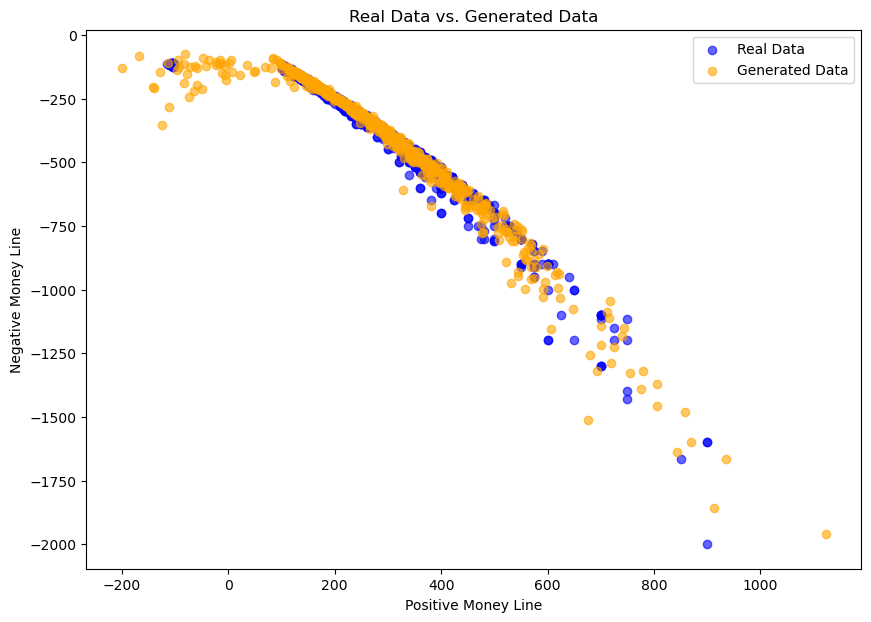

/Users/jake/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/jake/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/jake/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/jake/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version

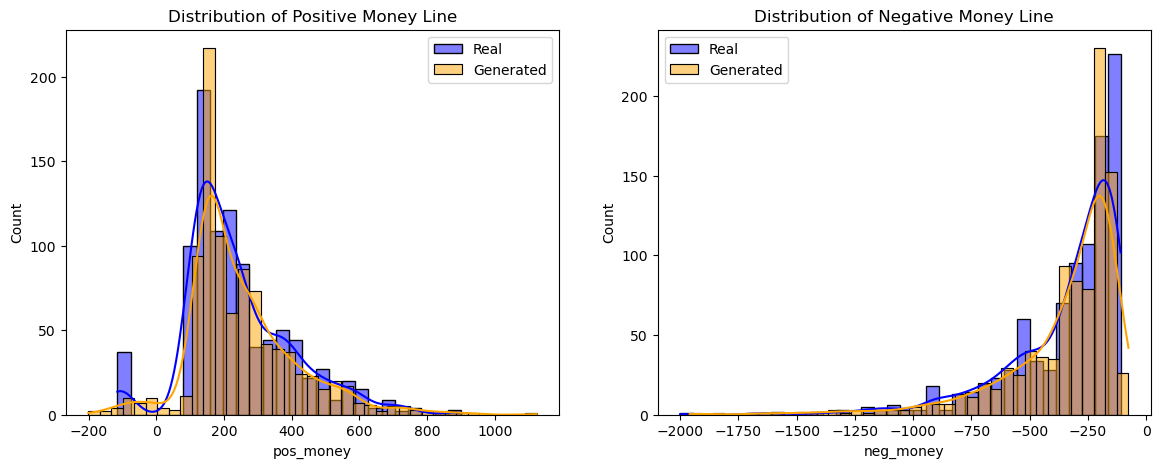

/Users/jake/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/jake/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/jake/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/jake/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version

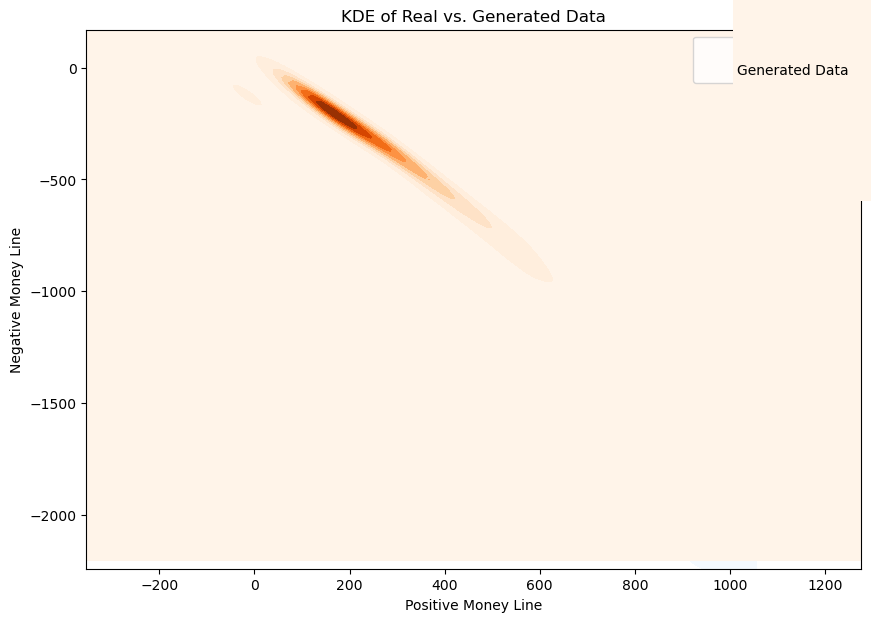

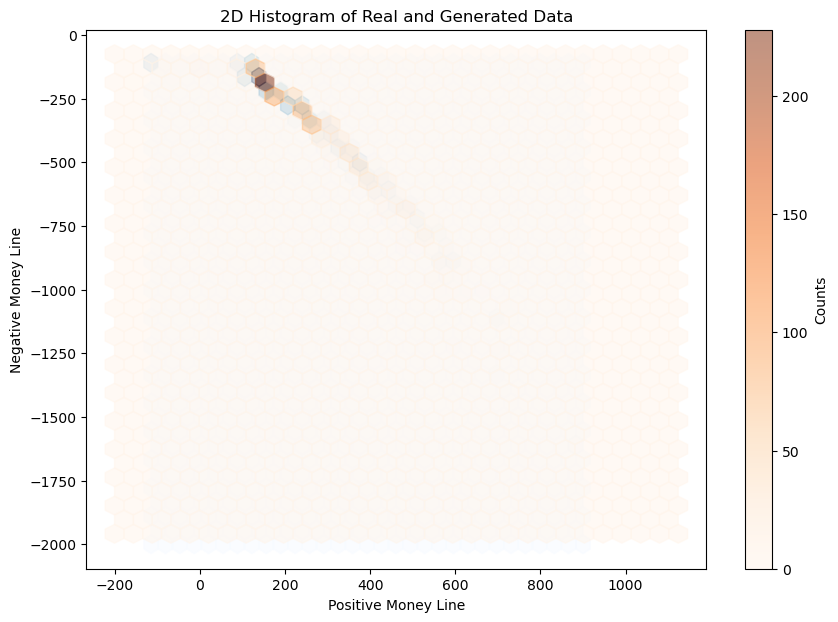

Kolmogorov-Smirnov Test Results:

Positive Moneyline:
KS statistic: 0.1168
p-value: 0.0000
Null hypothesis (distributions are the same): Rejected

Negative Moneyline:
KS statistic: 0.1189
p-value: 0.0000
Null hypothesis (distributions are the same): Rejected

Joint Distribution:
KS statistic: 0.0605
p-value: 0.0020
Null hypothesis (distributions are the same): Rejected
Wasserstein Distance Results:

Positive Moneyline: 13.1918
Negative Moneyline: 15.8556


{'positive': 13.19181473353866, 'negative': 15.85556975443652}

In [10]:
# Call all visualization and analysis functions
plot_real_vs_generated(real_df, gen_df)
# plot_training_losses(losses_G, losses_C)
plot_feature_distributions(real_df, gen_df)
plot_joint_kde(real_df, gen_df)
plot_2d_histogram(real_df, gen_df)
perform_ks_test(real_df, gen_df)
calculate_wasserstein_distances(real_df, gen_df)